# Fun with Census Data 

For a while, I've wanted to try doing some basic data analysis and visualizations in Python. So, I got some files from the 2010 US Census (available [here](https://www.census.gov/2010census/data/)). The data I worked with had some interesting facts about each state, going back every decade to 1910 (even states that weren't in the Union yet!). So I posed some questions and got to work.

In [47]:
import pandas as pd
import numpy as np
import math
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats  as stats

'''The population of each state at each decade, as well as the change from previous decade. 
X_POPULATION and X_CHANGE are the column names (X referring to a year ending with 10). 
There are these data for United States, Northeast, Midwest, South, West, 
Puerto Rico, and each individual state'''
pop_change_df = pd.read_csv('data/pop_change.csv', index_col=0, header=0, thousands=',')
pop_change_df.apply(pd.to_numeric)

'''The population density of each state. X_POPULATION, X_DENSITY, X_RANK are the keys'''
pop_density_df = pd.read_csv('data/pop_density.csv', index_col=0, header=0, skiprows=3, thousands=',')
pop_density_df.apply(pd.to_numeric)


'''The apportionment of representatives to the House by state. Keys include X_REPS,
X_PEOPLE_PER_REP, X_'''
apportionment_df = pd.read_csv('data/apportionment.csv', index_col=0, header=0, skiprows=1)
apportionment_df.apply(pd.to_numeric)
fix_nan_short = lambda num_or_nan: 0 if math.isnan(num_or_nan) else num_or_nan
apportionment_df = apportionment_df.applymap(fix_nan_short)

'''For some reason, 1920 people per rep is a column of zeroes. We can fix that here by just calculating it.'''
apportionment_df['1920_PEOPLE_PER_REP'] = pop_change_df['1920_POPULATION']/apportionment_df['1920_REPS']
fix_inf = lambda num_or_inf: math.nan if math.isinf(num_or_inf) else num_or_inf #this definitely works 
apportionment_df['1920_PEOPLE_PER_REP'] = apportionment_df['1920_PEOPLE_PER_REP'].apply(fix_inf)

'''The dataframes, but only with states.'''
states_pop_change = pop_change_df.iloc[range(5, len(pop_change_df))]
states_pop_density = pop_density_df.iloc[range(1, len(pop_density_df))]
state_apportionment = apportionment_df.iloc[range(1, len(apportionment_df))]

'''Takes in a function which itself reads an integer value of a valid year ending in 10. 
Valid years are 1910, 1920, ..., 2010. Returns a dictionary whose keys are years and 
values are func(year) for those years all of these years.'''
def values_for_all_years(func): 
    return_dict = {}
    for i in range(11): 
        return_dict[1910 + (10 * i)] = func(1910 + (10 * i))
    return return_dict

def n_max(year, number, fast): 
    key = str(year) + '_CHANGE'
    if fast: 
        return states_pop_change[key].nlargest(n=number)
    else: 
        return states_pop_change[key].nsmallest(n=number)

## What things influence state population growth? 

### Population Size

**Question 1**: What things make a state's population grow from one decade to the next? ([1] Here, state population growth is measured as a percentage of the previous decade's. So, if Texas had $1,000$ residents in 1930 and $1,500$ in 1940, it's 1940 population change would be $0.5$). 

Does a state's size in one year affect its growth in the next? I could have gone either way on  this one. There's the 'social proof' case to be made for the positive relationship - maybe people want to move to big states like New York and California where lots of exciting things are happening. On the other hand, maybe people want to move to smaller states, which life is quieter and land is cheaper. 

What I wasn't expecting is that there's little relationship at all. For every year in the data set, I calculated the correlation between states' population size (the total number of people in the state) in one year, and its population growth percentage for the next decade. 

Correlation between the two is sometimes positive, sometimes negative, and the correlation coefficient (I used [Pearson's r](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)) never exceeds 0.25 in absolute value. Clearly, there's no relationship that one could from these data.

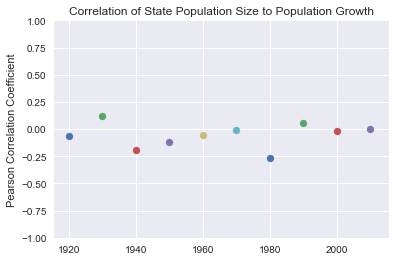

In [48]:
def corr_size_growth(initial_year): 
    size_key = str(initial_year) + '_POPULATION'
    growth_key = str(initial_year + 10) + '_CHANGE'
    corr_pvalue_tuple = stats.pearsonr(states_pop_change[size_key], states_pop_change[growth_key])
    plt.scatter(initial_year + 10, corr_pvalue_tuple[0])
    return corr_pvalue_tuple

plt.title('Correlation of State Population Size to Population Growth')
plt.ylim(-1.0, 1.0)
plt.ylabel('Pearson Correlation Coefficient')
size_growth_correlations = [corr_size_growth(1910 + (x * 10)) for x in range(10)]

Even 1980, which showed the strongest relationship of all the years measured, had a p-value of $p \approx 0.054$ - enough to reject the hypothesis at a significance level of $0.05$.

### Population Density

**Question 1 (Revised):** Maybe we need to pose a a stricter question. The factors I appealed to for both the postive and negative case might make more sense if we measured population *density* (that is, number of people per square mile) instead of population  *growth*. A big state like California isn't exciting if you live in Central Valley - you need to be in one of the big cities, where a huge number of people live close to each other. And life is only quieter (and land only cheaper)

What about population density? Does the number of people per square mile in a state affect its population growth? Well, sometimes. If we do the same thing as before - calculating correlation between a state's population density in one year, and then its population growth in the next decade, here's what we get.

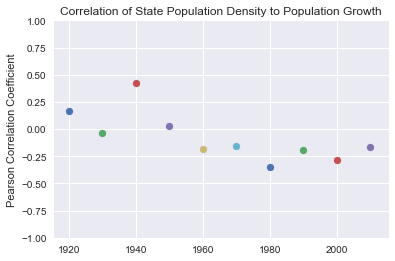

In [51]:
def corr_density_growth(initial_year): 
    density_key = str(initial_year) + '_DENSITY'
    growth_key = str(initial_year + 10) + '_CHANGE'
    corr_pvalue_tuple = stats.pearsonr(states_pop_density[density_key], states_pop_change[growth_key])
    plt.scatter(initial_year + 10, corr_pvalue_tuple[0])
    return corr_pvalue_tuple

plt.title('Correlation of State Population Density to Population Growth')
plt.xlabel=('Year')
plt.ylabel('Pearson Correlation Coefficient')
plt.ylim(-1.0, 1.0)
density_growth_correlations = [corr_density_growth(1910 + (x * 10)) for x in range(10)]

# for x in range(10): 
#     if (density_growth_correlations[x][1] < 0.05):
#         print (str(1920 + (10 * x)) + ': ' + str(density_growth_correlations[x][1]) + '\n')
#print(pop_change_df['1940_CHANGE'].nsmallest(n=5))

We might be gettign a little warmer. There's been a weak negative correlation since 1960, meaning dense states grow slower than sparse ones. Interestingly, though, the decade with the largest correlation showed the opposite. What's up with population growth from 1930-1940, during which the correlation was $r \approx 0.436$, and p-value was $p \approx 0.001$? In short, the Dust Bowl. This was the "largest migration in American history within a short period of time" during which more than 3.5 million people emigrated from the Plain States to the West. In fact, the top 5 fastest-shriking states were all from the Great Plains (the Dakotas, Nebraska, Kansas, and Oklahoma). ([3] Source: https://en.wikipedia.org/wiki/Dust_Bowl).

But that's a story for another post. 

## People per Representative

Unlike the Senate, the US House of Representatives gives more seats to big states than small ones. However, there are still disparities in representation ([4] The number of seats each state gets is determined by [priority values](https://www.census.gov/prod/cen2010/briefs/c2010br-08.pdf), which itself is an interesting story). The people per representative has grown every decade, as the US population has more than doubled while the House has had 435 seats since 1930.

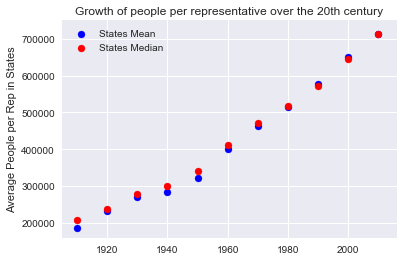

In [55]:
people_per_rep_2010 = apportionment_df['2010_PEOPLE_PER_REP']
pop_2010 = pop_density_df['2010_POPULATION']
#interesting. it seems like the states with shittiest representation are not the biggest but in fact the smallest

corr_popsize_people_per_rep = (pop_2010.corr(people_per_rep_2010, method='pearson'))

mean_people_per_rep = values_for_all_years(lambda year: state_apportionment[str(year) + '_PEOPLE_PER_REP'].mean())
std_people_per_rep = values_for_all_years(lambda year: state_apportionment[str(year) + '_PEOPLE_PER_REP'].std())
median_people_per_rep = values_for_all_years(lambda year: state_apportionment[str(year) + '_PEOPLE_PER_REP'].median())

for year in mean_people_per_rep.keys(): 
    x1 = plt.scatter(year, mean_people_per_rep[year], color='blue') #mean is blue
    x2 = plt.scatter(year, median_people_per_rep[year], color='red') #median is red 
plt.title('Growth of people per representative over the 20th century')
plt.ylabel('Average People per Rep in States')
plt.legend((x1, x2), ('States Mean', 'States Median'))
#so population has no correlation whatsoever with people per representative. 
#TODO: Data visualization here. X-axis can be size of population, and y-axis people per rep 
#TODO: Find out state trends in dilution of people per rep. 

In [ ]:
But apportionment results in 